In [15]:
import re
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from hydra import compose, initialize
import plotly.express as px

from src.analysis.utils import (
    get_elsevier_single_column_fig,
    get_elsevier_double_column_fig
)

In [ ]:
plt.rcParams.update({
    "font.size": 9,
})

SAVE_FIGURES = False

In [17]:
with initialize(version_base=None, config_path='../../src/conf'):
    cfg = compose(config_name="config")

In [18]:
figures_folder = Path('../../') / cfg['analysis']['figures_folder']
cells_paths = Path('../../') / cfg['data']['processed_cells_data_folder']

In [19]:
cells_paths = cells_paths.glob(pattern='*.parquet')
cells_paths = {cells_path.stem: cells_path for cells_path in cells_paths}

In [20]:
def load_cells_metadata(cells_paths: dict[str, Path]) -> pd.DataFrame:
    metadata = []
    soh_data = []

    for cell, cell_path in cells_paths.items():
        # Step 1: Read only the first row of 'charge_policy'
        charge_policy = pd.read_parquet(
            cell_path,
            columns=['charge_policy'],
            engine='pyarrow'
        ).iloc[0, 0]  # first row, first column

        # Step 2: Read only the needed columns for cycle_life calculation
        cycles_data = pd.read_parquet(
            cell_path,
            columns=['cycle', 'SOH'],
            engine='pyarrow'
        ).drop_duplicates()

        eol_soh = 80
        eol_idx = (cycles_data['SOH'] - eol_soh).abs().idxmin()
        cycle_life = cycles_data.loc[eol_idx, 'cycle']

        cycles_data['cell'] = cell
        soh_data.append(cycles_data)

        metadata.append({
            'cell': cell,
            'charge_policy': charge_policy,
            'cycle_life': cycle_life
        })

    return pd.DataFrame(metadata), pd.concat(soh_data)

In [21]:
metadata_df, soh_df = load_cells_metadata(cells_paths)

In [22]:
fig = px.line(
    soh_df,
    x="cycle",
    y="SOH",
    color="cell",  # Each line represents one cell
    hover_data=["cell", "cycle", "SOH"],  # Info shown when hovering
    labels={"cycle": "Cycle", "SOH": "State of Health", "cell": "Cell"},
    title="SOH vs. Cycle for Each Cell"
)

fig.update_traces(mode="lines+markers")  # Optional: adds visible points to help with hover
fig.update_layout(hovermode="x unified")  # Optional: shows all traces at same x

fig.show()

In [23]:
def extract_charge_policy_values(df: pd.DataFrame) -> pd.DataFrame:
    # Define regex pattern
    pattern = r'(\d+(?:\.\d+)?)C\((\d+)%\)-(\d+(?:\.\d+)?)C'

    # Function to extract values using regex
    def extract_values(policy: str):
        match = re.search(pattern, policy)
        if match:
            start_c = float(match.group(1))
            percent = float(match.group(2))
            end_c = float(match.group(3))
            return pd.Series([start_c, percent, end_c])
        else:
            return pd.Series([None, None, None])

    # Apply to dataframe
    df[['charge_step1', 'change_step_soc', 'charge_step2']] = df['charge_policy'].apply(extract_values)
    return df

In [24]:
metadata_df = extract_charge_policy_values(metadata_df)

In [25]:
metadata_df['mean_c-rate'] = (
    metadata_df['charge_step1'] * (metadata_df['change_step_soc']) +
    metadata_df['charge_step2'] * (80 - metadata_df['change_step_soc'])
) / 80
metadata_df = metadata_df.rename(
    columns={
        'cell': 'Cell',
        'charge_step1': 'Charge Step 1 C-rate',
        'charge_step2': 'Charge Step 2 C-rate',
        'change_step_soc': 'Change Step SoC',
        'cycle_life': 'Cell Cycle Life',
        'mean_c-rate': 'Mean Charge C-rate'
    }
)[[
    'Cell', 'Charge Step 1 C-rate', 'Charge Step 2 C-rate', 
    'Change Step SoC', 'Cell Cycle Life', 'Mean Charge C-rate'
]].dropna(axis=0)

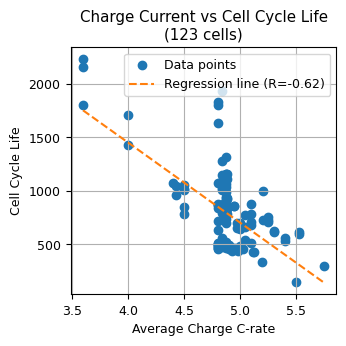

In [26]:
def plot_charge_current_and_cycle_life(
    df: pd.DataFrame,
    save_path: str = 'figures/charge_current_and_cycle_life.png'
) -> None:
    """Plot relationship between charge current and cycle life."""
    fig, ax = get_elsevier_single_column_fig()

    x = df['Mean Charge C-rate']
    y = df['Cell Cycle Life']

    # Scatter plot
    ax.scatter(x, y, label='Data points', c='C0')

    # Linear regression fit
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    x_fit = np.linspace(x.min(), x.max(), 100)
    y_fit = slope * x_fit + intercept
    ax.plot(x_fit, y_fit, c='C1', linestyle='--', label=f'Regression line (R={r_value:.2f})')

    # Labels and title
    ax.set_xlabel('Average Charge C-rate')
    ax.set_ylabel('Cell Cycle Life')
    ax.set_title(
        "Charge Current vs Cell Cycle Life\n"
        f"({len(df)} cells)"
    )

    ax.legend()
    ax.grid(True)
    if save_path is not None:
        plt.savefig(save_path, dpi=300)
    plt.show()

plot_charge_current_and_cycle_life(
    metadata_df, 
    save_path=(
        figures_folder / 'charge_current_and_cycle_life.png'
        if SAVE_FIGURES else None
    )
)

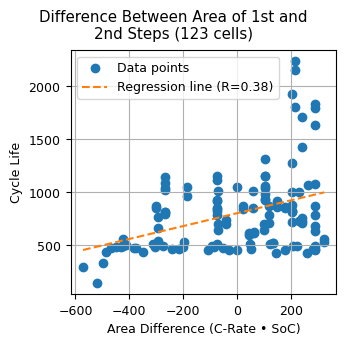

In [27]:
def plot_charge_steps_area_diff(
    charge_policies_df: pd.DataFrame,
    save_path: str = 'figures/charge_steps_area_diff.png'
) -> None:
    """Plot area difference between charge steps vs charge time and cycle life."""
    fig, ax = get_elsevier_single_column_fig()

    x = (
        charge_policies_df['Charge Step 1 C-rate']*(charge_policies_df['Change Step SoC']) - 
        charge_policies_df['Charge Step 2 C-rate']*(100 - charge_policies_df['Change Step SoC'])
    )
    y = charge_policies_df['Cell Cycle Life']

    # Plot cycle life vs area difference
    ax.scatter(x, y, label='Data points', c='C0')
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    x_fit = np.linspace(x.min(), x.max(), 100)
    y_fit = slope * x_fit + intercept
    ax.plot(x_fit, y_fit, c='C1', linestyle='--', label=f'Regression line (R={r_value:.2f})')
    ax.set_xlabel('Area Difference (C-Rate • SoC)')
    ax.set_ylabel('Cycle Life')
    ax.legend()
    ax.grid(True)
    fig.suptitle(
        "Difference Between Area of 1st and\n"
        f"2nd Steps ({len(charge_policies_df)} cells)"
    )
    if save_path is not None:
        plt.savefig(save_path, dpi=300)
    plt.show()

plot_charge_steps_area_diff(
    metadata_df, 
    save_path=(
        figures_folder / 'charge_steps_area_diff.png'
        if SAVE_FIGURES else None
    )
)

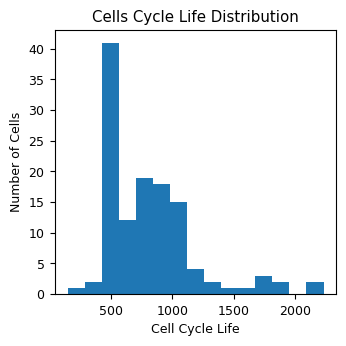

In [28]:
def plot_cycle_life_distribution(
    data: pd.DataFrame,
    save_path: str = 'figures/charge_steps_area_diff.png'
) -> None:
    fig, ax = get_elsevier_single_column_fig()
    ax.hist(data['Cell Cycle Life'], bins=15)
    
    ax.set_xlabel('Cell Cycle Life')
    ax.set_ylabel('Number of Cells')
    
    ax.set_title('Cells Cycle Life Distribution')
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()

plot_cycle_life_distribution(
    metadata_df, 
    save_path=(
        figures_folder / 'cycle_life_distribution.png'
        if SAVE_FIGURES else None
    )
)